In [1]:
from craft_text_detector import (
    read_image,
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
)

refine_net = load_refinenet_model(cuda=False)
craft_net = load_craftnet_model(cuda=False)

ModuleNotFoundError: No module named 'craft_text_detector'

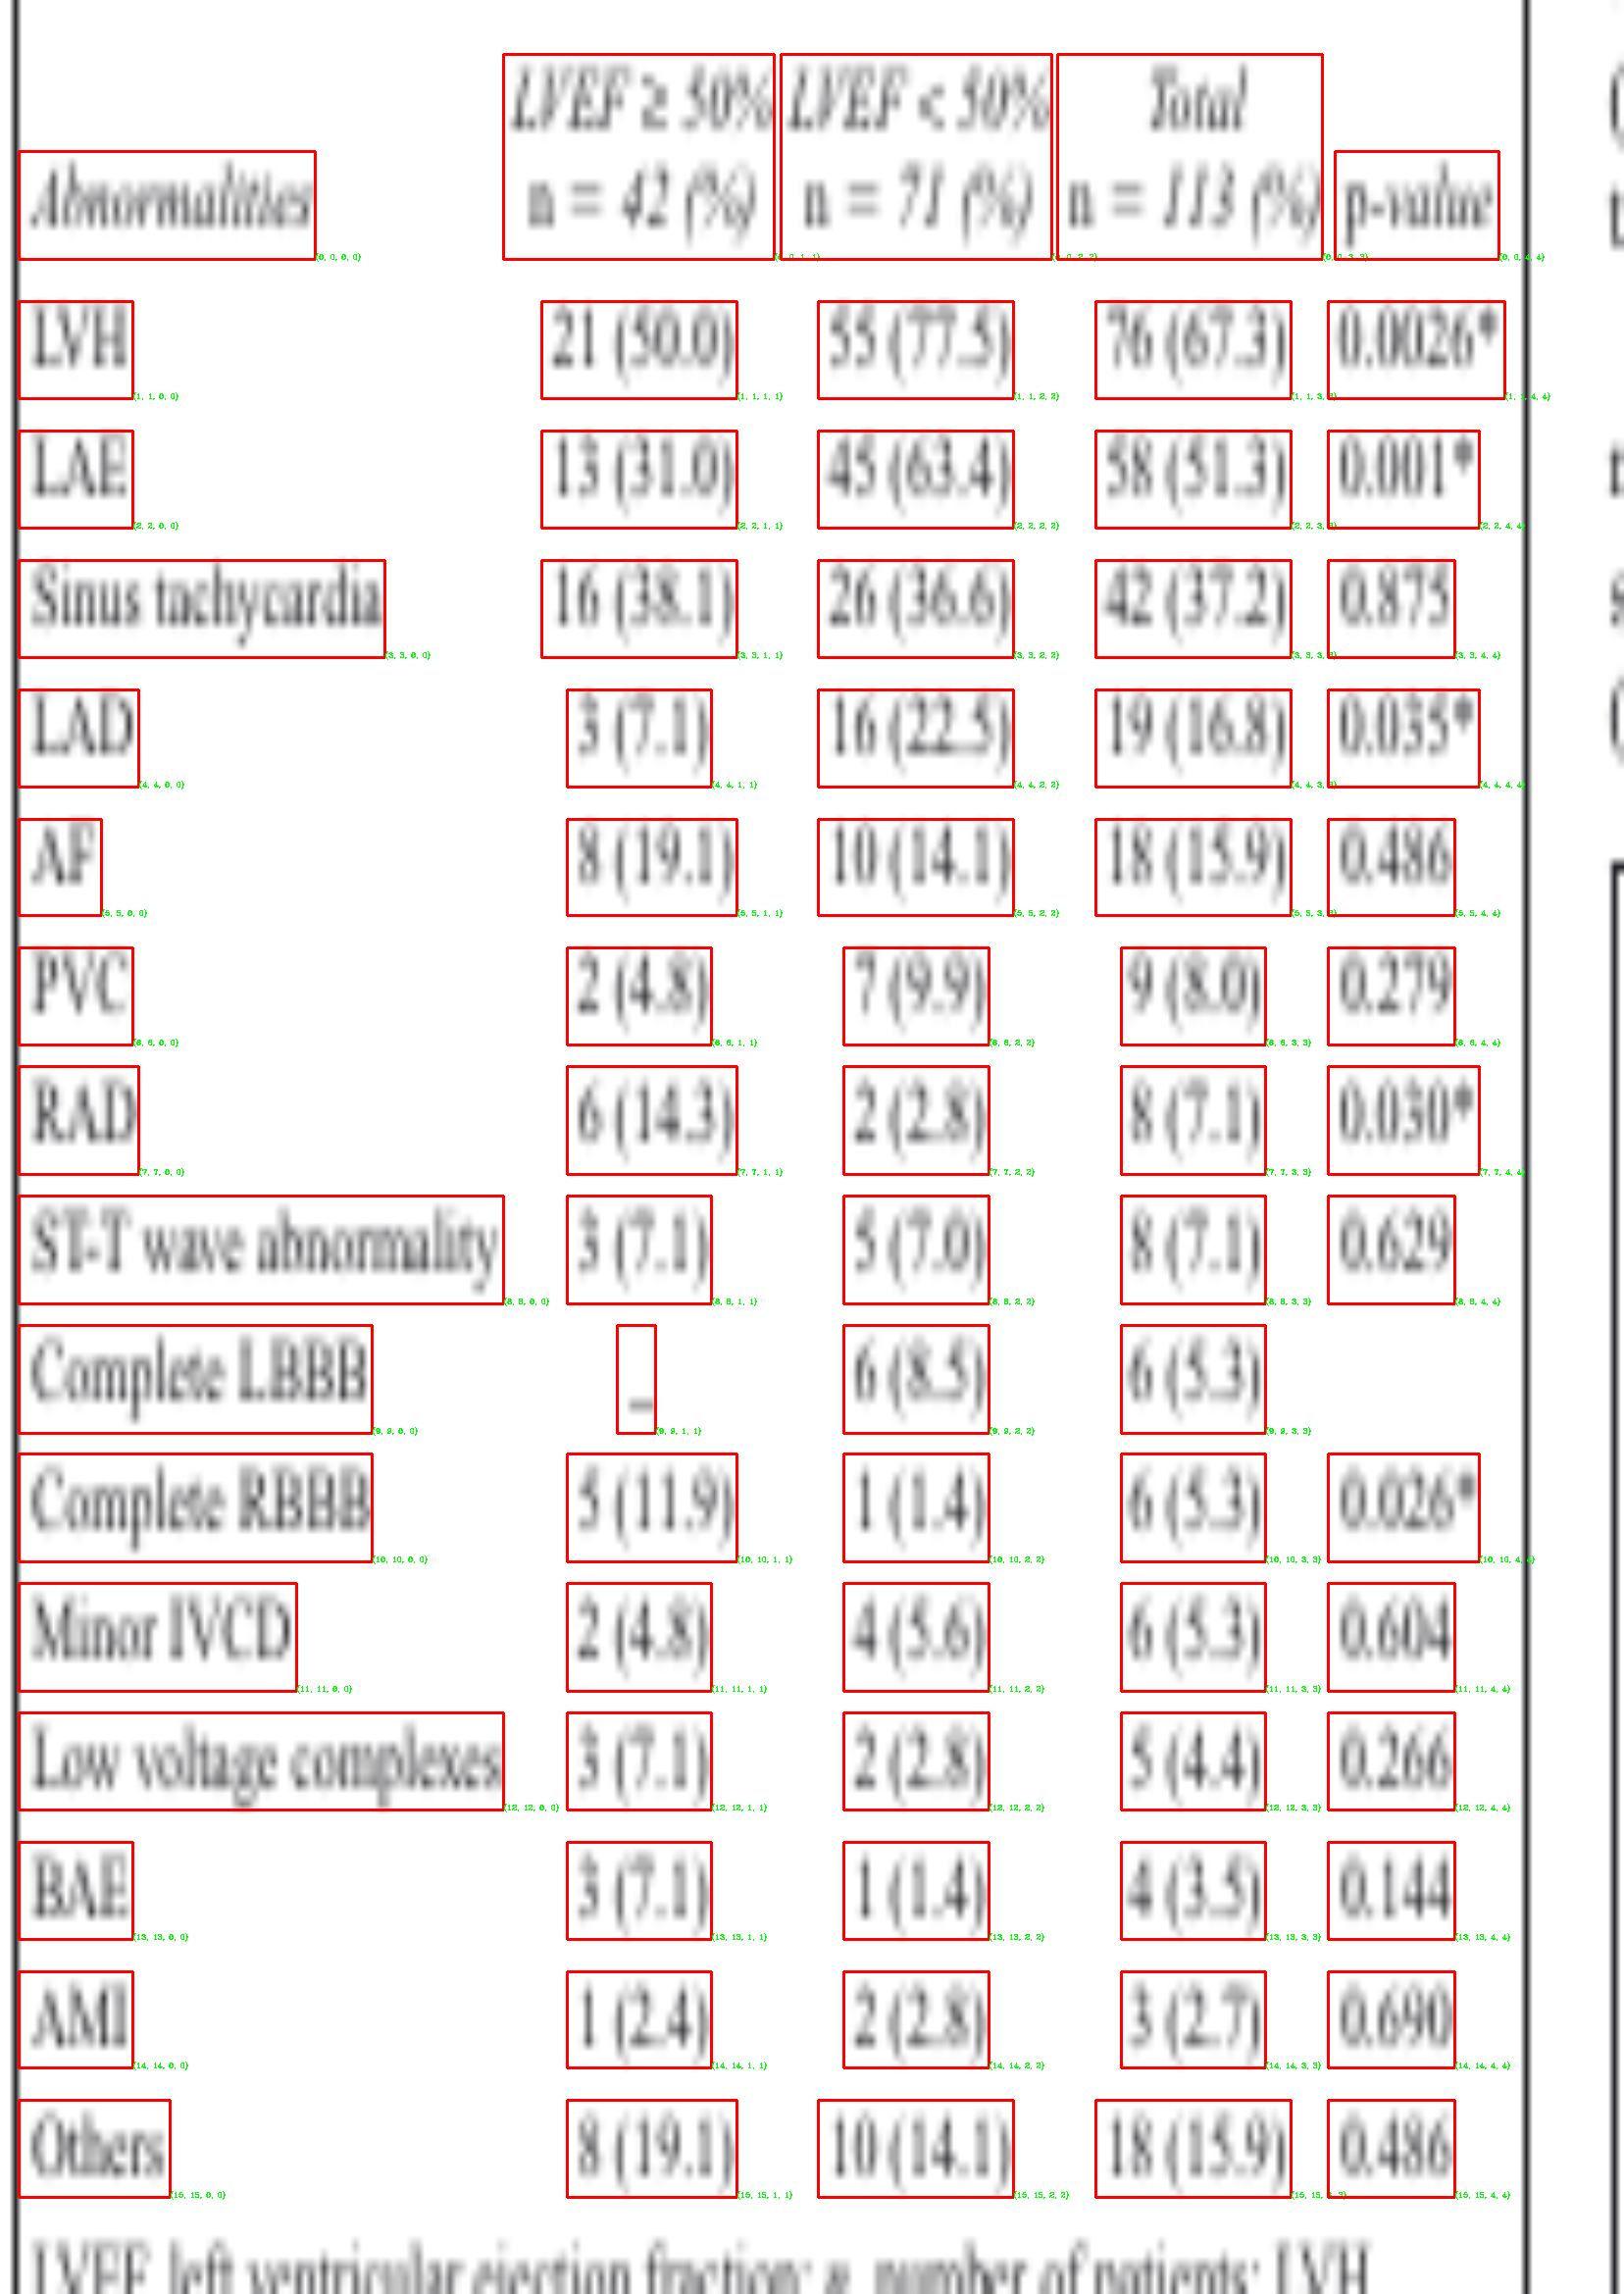

OSError: [Errno 28] No space left on device

In [3]:
import json
from PIL import Image
import os
import cv2
import numpy as np
import jsonlines
from glob import glob
from IPython.display import clear_output

X_image_def = 1656
Y_image_def = 2339
tables = {"test": [],
          "train": [],
          "val": [],
          }
l = {
    "train":500777,
    "val":9115,
    "test":9138,
}

each = 1000
os.makedirs("/Volumes/Seagate/Initflow/PubTabNetDs/pubtabnetresized/test", exist_ok=True)
os.makedirs("/Volumes/Seagate/Initflow/PubTabNetDs/pubtabnetresized/train", exist_ok=True)
os.makedirs("/Volumes/Seagate/Initflow/PubTabNetDs/pubtabnetresized/val", exist_ok=True)
frm = 80000

# Loading an example annotation
with jsonlines.open('/Volumes/Seagate/Initflow/PubTabNetDs/pubtabnet/PubTabNet_2.0.0.jsonl', 'r') as reader:
    for num, img_data_i in enumerate(reader):
        if (num + 1) <= 80000:
            continue
        structure = img_data_i['html']['structure']['tokens']
        cells = img_data_i['html']['cells']

        i_cell = -1
        table = []

        n_row = 0
        n_col = 0
        cell = {
                'col_start': None,
                'row_start': None,
                'col_end': None,
                'row_end': None,
                'bbox': None,
                'text': None,
                }


        img_table = cv2.imread(f"/Volumes/Seagate/Initflow/PubTabNetDs/pubtabnet/{img_data_i['split']}/{img_data_i['filename']}")
        y_tabel_img, x_tabel_img, _ = img_table.shape
        img_table = cv2.resize(img_table, (X_image_def, Y_image_def)) #, interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(f"/Volumes/Seagate/Initflow/PubTabNetDs/pubtabnetresized/{img_data_i['split']}/{img_data_i['filename']}", img_table)

        for tag in structure:

            # print(tag)
            if (tag == '<td>') or (tag == '<td'):
                cell['col_start'] = n_col
                cell['col_end'] = n_col
                cell['row_start'] = n_row
                cell['row_end'] = n_row

            elif "colspan" in tag:
                colspan = tag.replace(' colspan="', "")
                colspan = colspan.replace('"', "")
                cs = n_col + int(colspan) - 1
                cell['col_end'] = cs

            elif "rowspan" in tag:
                rowspan = tag.replace(' rowspan="', "")
                rowspan = rowspan.replace('"', "")
                rs = n_row + int(rowspan) - 1
                cell['row_end'] = rs

            elif tag == '</td>':
                i_cell += 1
                n_col += 1
                text_box = cells[i_cell]
                if (len(text_box.keys()) == 1) and ('tokens' in list(text_box.keys())):
                    cell = {
                            'col_start': None,
                            'row_start': None,
                            'col_end': None,
                            'row_end': None,
                            'bbox': None,
                            'text': None,
                            }
                    continue

                text = text_box['tokens']

                text = "".join(text)
                text = text.replace('<b>', '').replace('</b>', '').replace('<i>', '').replace('</i>', '')

                bbox = np.array(text_box['bbox'])
                scale_x = X_image_def / x_tabel_img
                scale_y = Y_image_def / y_tabel_img

                bbox[0] = int(np.round(bbox[0] * scale_x))
                bbox[1] = int(np.round(bbox[1] * scale_y))
                bbox[2] = int(np.round(bbox[2] * scale_x))
                bbox[3] = int(np.round(bbox[3] * scale_y))

                cell['bbox'] = bbox.tolist()


                cell['text'] = text
                if (num + 1) % each == 0:
                    display(img_data_i['filename'])
                    display(img_data_i['split'])
                    display(num+1)
                    img_table = cv2.rectangle(img_table, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), thickness=2)
                    img_table = cv2.putText(img_table,
                                            f"({cell['row_start']}, {cell['row_end']}, {cell['col_start']}, {cell['col_end']})",
                                            (bbox[2], bbox[3]),
                                            cv2.FONT_HERSHEY_COMPLEX,
                                            0.25,
                                            (0, 255, 0),
                                            1,
                                            )
                    

                table.append(cell.copy())
                cell = {
                        'col_start': None,
                        'row_start': None,
                        'col_end': None,
                        'row_end': None,
                        'bbox': None,
                        'text': None,
                        }

            elif tag == '</tr>':
                n_row += 1
                n_col = 0

        tables[img_data_i['split']].append({img_data_i['filename']:table})

        display(f"{num + 1}/{l[img_data_i['split']]} split: {img_data_i['split']}")
        clear_output(wait=True)
        if (num + 1) % each == 0:
            display(Image.fromarray(img_table))

        if (num + 1) % 5000 == 0:
            with open(f'ds_anns_pubnet/anns_{frm}_{num+1}_{sum(l.values())}.json', 'w') as json_file:
                json.dump(tables, json_file, ensure_ascii=False)
            frm = num + 2

In [1]:
l = {
    "train":500777,
    "val":9115,
    "test":9138,
}
sum(l.values())

519030

In [ ]:
tables = {'tables': []}
for img_data in [imgs_data[3]]:
    table_crop_img = cv2.imread(f"/content/examples/examples/{img_data['filename']}")
    # perform prediction
    prediction_result = get_prediction(
        image=table_crop_img,
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.0000001,
        link_threshold=0.71,
        low_text=0.3,
        cuda=True,
        long_size=1580,
    )

    # PLOT CRAFT
    # table_crop_img_ = table_crop_img.copy()
    # for box in prediction_result['boxes']:
    #     x, y, w, h = cv2.boundingRect(box)
    #     # table_crop_img_ = cv2.polylines(table_crop_img_, [np.array(i).astype(int)], True, color=(0, 255, 0), thickness=2)
    #     table_crop_img_ = cv2.rectangle(table_crop_img_, (x, y), (x+w, y+h), (255, 0, 0), thickness=2)
    
    # display(ImagePil.fromarray(table_crop_img_))

    # cells = prediction_result['boxes']
    # cells_text = []
    # for c in cells:
    #     x, y, w, h = cv2.boundingRect(c)
    #     cell = [x, y, x+w, y+h]
    #     cells_text.append({"cell": cell, "text": get_text(c, table_crop_img)})

In [ ]:
test = cv2.imread("/Users/dmitry/Initflow/TableRecognition/DatasetProcessing/preproc/dataset_before_filter/15_6.jpg")

In [2]:
with open("/Users/dmitry/Initflow/pubtabnetds/ds_anns_pubnet/anns_1_80000_519030.json") as f:
    d = json.load(f)
